Make true-colour cutouts from HSC data

In [7]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import lsst.afw.display.rgb as afwRgb
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

In [9]:
import os

if "SUPRIME_DATA_DIR" not in os.environ:
    os.environ["SUPRIME_DATA_DIR"] = "/tigress/HSC/HSC" if True else \
                                     "/lustre/Subaru/SSP"
        
dataPath = os.path.join(os.environ["SUPRIME_DATA_DIR"], "rerun", "production-20151224")

butler = dafPersist.Butler(dataPath)
skymap = butler.get("deepCoadd_skyMap")

Select the object we want to make a Pretty Picture of

In [23]:
ra, dec = (
    (215.9747, -0.4344) if True else
    (35.510021299465485, -3.826884926430952) if True else
    (36.134336058339706, -4.2434119608421064) if True else
    (130.591168, 1.640672)
)
    
raDec = afwCoord.Coord(ra*afwGeom.degrees, dec*afwGeom.degrees)

filters = "grizy"  # filters to process -- we choose our bands when we set B, R, G = ...

cutoutSize = 500   # pixels

Figure out the area we want, and read the data.

For coadds the WCS is the same in all bands, but the code handles the general case

Start by finding the tract and patch

In [24]:
tractInfo, patchInfo = skymap.findClosestTractPatchList([raDec])[0]
#print raDec, skymap.findClosestTractPatchList([raDec])
tract = tractInfo.getId()
patch = "%d,%d" % patchInfo[0].getIndex()

print tract, patch

9372 6,6


Then we can read the desired pixels

(We don't use the butler to get the subimage in case it has a PSF that we can't read)

In [25]:
images = {}
cutoutSize = 200

for f in filters:
    filterName = "HSC-%s" % f.upper()
    md = butler.get("deepCoadd_calexp_md", immediate=True,
                    tract=tract, patch=patch, filter=filterName)
    wcs = afwImage.makeWcs(md)
    xy = afwGeom.PointI(wcs.skyToPixel(raDec))

    llc = afwGeom.PointI(xy - afwGeom.ExtentI(cutoutSize//2, cutoutSize//2) - 
                         afwGeom.ExtentI(-md.get("LTV1"), -md.get("LTV2")))
    bbox = afwGeom.BoxI(llc, afwGeom.ExtentI(cutoutSize, cutoutSize))

    if False:
        fileName = butler.get("deepCoadd_calexp_filename", immediate=True,
                              tract=tract, patch=patch, filter=filterName)[0]

        md = None
        images[f] = afwImage.MaskedImageF(fileName, md, bbox)
    else:
        images[f] = butler.get("deepCoadd_calexp_sub", bbox=bbox, immediate=True,
                               tract=tract, patch=patch, filter=filterName).getMaskedImage()

In [34]:
dataId = dict(tract=tract, patch=patch, filter=filterName)
fn = butler.get("deepCoadd_calexp_filename", dataId)[0]
import lsst.afw.image as afwImage

exp = afwImage.ExposureF(fn, bbox)

<lsst.afw.image.imageLib.ExposureF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::Exposure< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x2b69d4ea1240> >


Generate a RGB images, and optionally write to disk

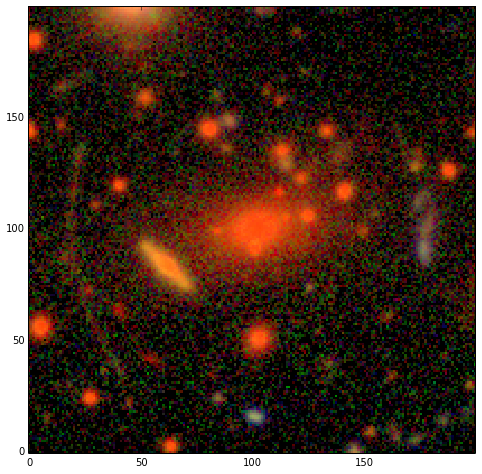

gri


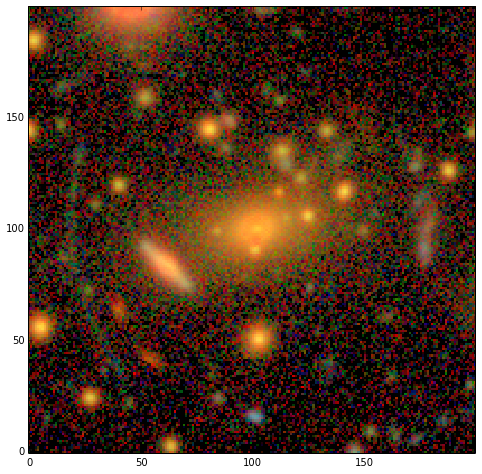

riz


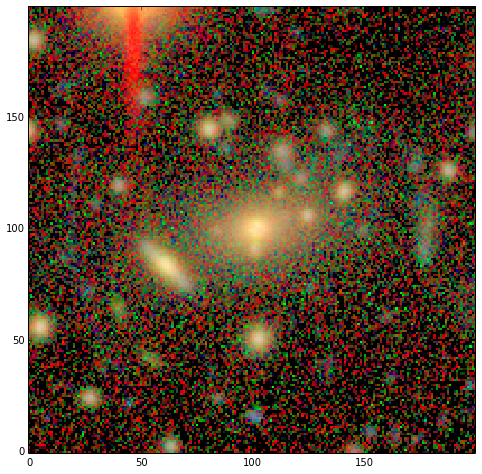

izy


In [26]:
rgbFileFmt = "foo-%s.png" if False else None
min = -0.0
max = 0.3
Q = 8

for bands in ["gri", "riz", "izy"]:
    B, G, R = bands
    rgb = afwRgb.makeRGB(images[R].getImage(), images[G].getImage(), images[B].getImage(), min, max - min, Q)
    
    afwRgb.displayRGB(rgb)
    print bands
    
    if rgbFileFmt:
        afwRgb.writeRGB(rgbFileFmt % bands, rgb)